# Evaluation of IMDB Movie Rating Prediction Model

- Because our features do not fit well in sklearn framework do the data cleaning, imputation manually. 
- Pay special attention on not using any test data while training!

# Load Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing, linear_model, ensemble, metrics
%matplotlib inline

In [2]:
filepath = '/Users/vug/Downloads/movie_metadata.csv'
filepath = r'C:\Users\veliu\Downloads\movie_metadata.csv'

In [4]:
df = pd.read_csv(filepath)

# Drop features
to_drop = ['country', 'language', 'movie_imdb_link']
df.drop(to_drop, axis=1, inplace=True)

FEATURES_TEXT = sorted(df.dtypes[df.dtypes == 'object'].index.values.tolist())
FEATURES_NUMERIC = sorted(set(df.columns) - set(FEATURES_TEXT))
FEATURES_CATEGORICAL = ['actor_1_name', 'actor_2_name', 'actor_3_name', 'color', 'content_rating', 'director_name']

## Function Library

In [ ]:
def get_all_items_and_most_common(series):
    """Given a column of which elements are strings with | separator return all items in that column and most common one."""
    nested_list = series.apply(lambda x: x.split('|') if not type(x) == float else []).values
    all_items = pd.Series(np.hstack(nested_list))
    unique_items = all_items.unique()
    return sorted(unique_items), all_items.value_counts().index[0]

def get_item_scores(df, items, column):
    """Given the list of all items return the a dictionary where keys are items and values are lists of scores earn by those items."""
    item_scores = {item: [] for item in items}
    for ix, row in df.iterrows():
        if type(row[column]) == str:
            for item in row[column].split('|'):
                item_scores[item].append(row.imdb_score)
    return item_scores

def get_average_scores(scores):
    ave_scores = dict()
    for key, scores in scores.items():
        ave_scores[key] = sum(scores) / len(scores)
    return ave_scores

def get_label_encoder(series):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(series)
    return label_encoder

def get_one_hot_encoder(series):
    one_hot_encoder = preprocessing.OneHotEncoder()
    one_hot_encoder.fit(series)
    return one_hot_encoder

def one_hot_encode(series, label_encoder, one_hot_encoder):
    label_encoded = label_encoder.transform(series)
    one_hot_encoded = one_hot_encoder.transform(label_encoded)
    return one_hot_encoded

def analyze_training_set(df):
    """Prepare necessary data to be able to impute test set, such as most common values."""
    keywords, mc_keyword = get_all_items_and_most_common(df.plot_keywords)
    genres, mc_genre = get_all_items_and_most_common(df.genres)
    directors, mc_director = get_all_items_and_most_common(df.director_name)
    all_actors = df.actor_1_name.values.tolist() + df.actor_2_name.values.tolist() + df.actor_3_name.values.tolist()
    all_actors = [a for a in all_actors if type(a) == str]
    actors = sorted(set(all_actors))
    mc_actor = pd.Series(all_actors).value_counts().index[0]
    
    medians = {col: df[col].median() for col in FEATURES_NUMERIC}
    most_common_values = {col: df[col].value_counts().index[0] for col in FEATURES_CATEGORICAL}
    all_values = {col: df[col].unique() for col in FEATURES_CATEGORICAL}
    
    keyword_scores = get_item_scores(df, keywords, 'plot_keywords')
    genre_scores = get_item_scores(df, genres, 'genres')
    director_scores = get_item_scores(df, directors, 'director_name')
    actor_scores = {actor: [] for actor in actors}
    for ix, row in df.iterrows():
        for a in [row.actor_1_name, row.actor_2_name, row.actor_3_name]:
            if type(a) == str:
                actor_scores[a].append(row.imdb_score)    
        
    return (keywords, mc_keyword, keyword_scores,
            genres, mc_genre, genre_scores,
            directors, mc_director, director_scores,
            actors, mc_actor, actor_scores,
            medians, most_common_values, all_values)

def impute_dataset(df, medians, most_common_values, all_values, mc_keyword, mc_actor):
    """Given the collected statistics from training set, impute missing data."""
    for col in FEATURES_NUMERIC:
        df[col].fillna(medians[col], inplace=True)
    for col in FEATURES_CATEGORICAL:
        df[col].fillna(most_common_values[col], inplace=True)
        # If a value is not seen in training set, replace it with most common value in training set.
        df[col] = df[col].apply(lambda s: s if s in all_values[col] else most_common_values[col])
    df.plot_keywords.fillna(mc_keyword, inplace=True)
    df.actor_1_name.fillna(mc_actor, inplace=True)
    df.actor_2_name.fillna(mc_actor, inplace=True)
    df.actor_3_name.fillna(mc_actor, inplace=True)
    
def analyze_training_set2(df):
    """Handle feature that needs one-hot encoding."""
    color_label_encoder = get_label_encoder(df.color)
    color_label_encoded = color_label_encoder.transform(df.color).reshape(-1, 1)
    color_one_hot_encoder = get_one_hot_encoder(color_label_encoded)
    rating_label_encoder = get_label_encoder(df.content_rating)
    rating_label_encoded = rating_label_encoder.transform(df.content_rating).reshape(-1, 1)
    rating_one_hot_encoder = get_one_hot_encoder(rating_label_encoded)
    return color_label_encoder, color_one_hot_encoder, rating_label_encoder, rating_one_hot_encoder 
    
    
def extract_features(df, mc_actor, mc_genre, mc_keyword, mc_director,
                    color_label_encoder, color_one_hot_encoder, rating_label_encoder, rating_one_hot_encoder):
    """Extract features such as actors, genres, directors average scores."""
    keyword_ave_scores = get_average_scores(keyword_scores)
    genre_ave_scores = get_average_scores(genre_scores)
    actor_ave_scores = get_average_scores(actor_scores)
    director_ave_scores = get_average_scores(director_scores)
    ave_keyword_scr = keyword_ave_scores[mc_keyword]
    ave_actor_scr = actor_ave_scores[mc_actor]
    ave_genre_scr = genre_ave_scores[mc_genre]
    ave_director_scr = director_ave_scores[mc_director]
    
    df.loc[:, 'actor_1_ave_score'] = df.actor_1_name.apply(lambda name: actor_ave_scores.get(name, ave_actor_scr))
    df.loc[:, 'actor_2_ave_score'] = df.actor_2_name.apply(lambda name: actor_ave_scores.get(name, ave_actor_scr))
    df.loc[:, 'actor_3_ave_score'] = df.actor_3_name.apply(lambda name: actor_ave_scores.get(name, ave_actor_scr))
    splitted = df.genres.apply(lambda s: s.split('|'))
    df.loc[:, 'genres_ave_score'] = splitted.apply(lambda genres: sum([genre_ave_scores.get(g, ave_genre_scr) for g in genres]) / len(genres))
    splitted = df.plot_keywords.apply(lambda s: s.split('|'))
    df.loc[:, 'keywords_ave_score'] = splitted.apply(lambda keywords: sum([keyword_ave_scores.get(k, ave_keyword_scr) for k in keywords]) / len(keywords))
    df.loc[:, 'director_ave_score'] = df.director_name.apply(lambda name: director_ave_scores.get(name, ave_director_scr))
    
    color_label_encoded = color_label_encoder.transform(df.color).reshape(-1, 1)
    X_color = color_one_hot_encoder.transform(color_label_encoded).toarray()
    rating_label_encoded = rating_label_encoder.transform(df.content_rating).reshape(-1, 1)
    X_rating = rating_one_hot_encoder.transform(rating_label_encoded).toarray()
    
    X_numeric = df[['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes',
       'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews',
       'budget', 'title_year', 'actor_2_facebook_likes', 'actor_1_ave_score', 'actor_2_ave_score', 'actor_3_ave_score',
       'genres_ave_score', 'keywords_ave_score', 'director_ave_score']].values
    
    X = np.hstack([X_numeric, X_color, X_rating])    
    y = df.imdb_score.values
    return X, y

def plot_actual_vs_prediction(predicted, actual):
    plt.scatter(predicted, actual, lw=0, alpha=0.2)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.plot([0, 10], [0, 10], color='red', lw=2, linestyle='--')
    plt.xlim([0, 10])
    plt.ylim([0, 10])

# Model evaluation via cross-validation

We'll choose two simple models and feed them with our features. Because training and test sets are not given separatly, I'm going to do cross-validation, i.e. dataset set will be split into training and test sets multiple times, each time from a different location.

For each split predictions and errors are calculated.

In [174]:
errors1 = []
plot_data1 = []
errors2 = []
plot_data2 = []
kf = model_selection.KFold(n_splits=10, random_state=2)
for train_ix, text_ix in reversed(list(kf.split(df.values))):
# ss = model_selection.ShuffleSplit(n_splits=5, test_size=0.05, random_state=3)
# for train_ix, text_ix in ss.split(df.values):
    df_train = df.iloc[train_ix, :]
    df_test = df.iloc[text_ix, :]   
    
    (keywords, mc_keyword, keyword_scores, 
     genres, mc_genre, genre_scores, 
     directors, mc_director, director_scores,
     actors, mc_actor, actor_scores,
     medians, most_common_values, all_values) = analyze_training_set(df_train)
    
    d = df_train.copy()
    impute_dataset(d, medians, most_common_values, all_values, mc_keyword, mc_actor)
    color_label_encoder, color_one_hot_encoder, rating_label_encoder, rating_one_hot_encoder = analyze_training_set2(d)
    X_train, y_train = extract_features(d, mc_actor, mc_genre, mc_keyword, mc_director,
                                       color_label_encoder, color_one_hot_encoder, rating_label_encoder, rating_one_hot_encoder)    
    
    e = df_test.copy()
    impute_dataset(e, medians, most_common_values, all_values, mc_keyword, mc_actor)
    X_test, y_test = extract_features(e, mc_actor, mc_genre, mc_keyword, mc_director,
                                     color_label_encoder, color_one_hot_encoder, rating_label_encoder, rating_one_hot_encoder)    

    regr1 = linear_model.LinearRegression()
    regr1.fit(X_train, y_train)
    predicted1 = regr1.predict(X_test)
    plot_data1.append([predicted1, y_test])
    errors1 = 
    
    regr2 = ensemble.RandomForestRegressor()
    regr2.fit(X_train, y_train)
    predicted2 = regr2.predict(X_test)
    plot_data2.append([predicted2, y_test])

# Baselines

Error if we guess IMDB scores totally randomly.

In [ ]:
y_random = np.random.rand(len(plot_data[k][1])) * 10.

In [207]:
base_err_mean_abs = metrics.mean_absolute_error(y_random, plot_data[k][1])
base_err_mean_sqr = metrics.mean_squared_error(y_random, plot_data[k][1])
base_err_med_abs = metrics.median_absolute_error(y_random, plot_data[k][1])

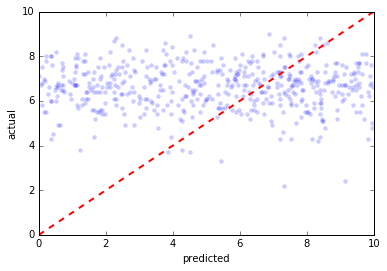

In [208]:
plot_actual_vs_prediction(y_random, plot_data1[k][1])

# Linear Regression Model Errors

In [209]:
lr_err_mean_abs = np.mean([metrics.mean_absolute_error(plot_data1[k][0], plot_data1[k][1]) for k in range(len(plot_data1))])
lr_err_mean_sqr = np.mean([metrics.mean_squared_error(plot_data1[k][0], plot_data1[k][1]) for k in range(len(plot_data1))])
lr_err_med_abs = np.mean([metrics.median_absolute_error(plot_data1[k][0], plot_data1[k][1]) for k in range(len(plot_data1))])

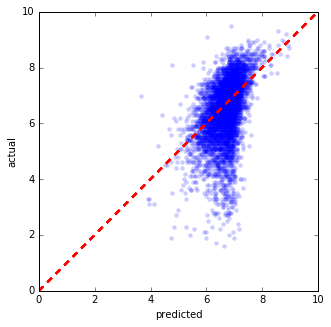

In [201]:
plt.figure(figsize=(5, 5))
for k in range(len(plot_data1)):
    plot_actual_vs_prediction(plot_data1[k][0], plot_data1[k][1])

## Random Forest Errors 

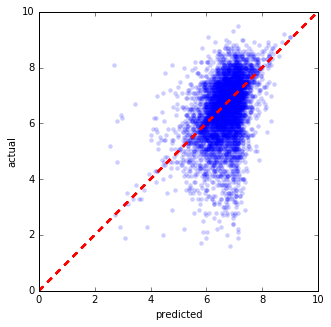

In [202]:
plt.figure(figsize=(5, 5))
for k in range(len(plot_data2)):
    plot_actual_vs_prediction(plot_data2[k][0], plot_data2[k][1])

In [213]:
rf_err_mean_abs = np.mean([metrics.mean_absolute_error(plot_data2[k][0], plot_data2[k][1]) for k in range(len(plot_data2))])
rf_err_mean_sqr = np.mean([metrics.mean_squared_error(plot_data2[k][0], plot_data2[k][1]) for k in range(len(plot_data2))])
rf_err_med_abs = np.mean([metrics.median_absolute_error(plot_data2[k][0], plot_data2[k][1]) for k in range(len(plot_data2))])

In [214]:
pd.DataFrame(data={'baseline': [base_err_mean_abs, base_err_mean_sqr, base_err_med_abs],
                   'linear model': [lr_err_mean_abs, lr_err_mean_sqr, lr_err_med_abs],
                   'random forest model': [rf_err_mean_abs, rf_err_mean_sqr, rf_err_med_abs]},
             index=['mean absolute error', 'mean square error', 'meadian absolute error'])

,baseline,linear model,random forest model
mean absolute error,2.793953,0.745422,0.777153
mean square error,11.558247,1.046932,1.146965
meadian absolute error,2.434636,0.561921,0.583000


# Conclusion

- There is not much difference between linear and random forest model.
- For mean square error there is a 10 fold reduction in the prediction error compared to the baseline.